In [1]:
import sys
import numpy as np
import xarray as xr
import cmaps
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
ccmap = cmaps.ncl_default
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.colors import BoundaryNorm
from cartopy.util import add_cyclic_point
ccmap1 = cmaps.NEO_div_vegetation_a
plt.rcParams['font.family'] = 'Arial'

# 定义函数

In [8]:
def calculate_consistency_2d(model_trends, ensemble_trend):
    num_models = model_trends.shape[0]
    consistency_mask = np.full(ensemble_trend.shape, False)
    for i in range(ensemble_trend.shape[0]):
        for j in range(ensemble_trend.shape[1]):
            # 计算与集合平均趋势符号一致的模式数量
            num_consistent_models = np.sum(np.sign(model_trends[:, i, j]) == np.sign(ensemble_trend[i, j]))
            # 判断是否超过80%
            if num_consistent_models / num_models >= 0.8:
                consistency_mask[i, j] = True
    return consistency_mask

def plot_meri_section(ax1, lat,level,level_label,
                      meri_data,meri_data_levels,ccmap,meri_clim,meri_clim_levels,mme_consistency,set_xticks,
                      left_title,colorbar_label,color_bar_ticks,sequence):

    cycle_data, cycle_lat = add_cyclic_point(meri_data, coord=lat)
    cycle_lat, cycle_level = np.meshgrid(cycle_lat, np.arange(level.shape[0]))
    #cycle_MON = cycle_MON.filled(np.nan)
    cycle_data = cycle_data.filled(np.nan)

    c1 = ax1.contourf(cycle_lat, cycle_level, cycle_data, cmap=ccmap, levels=meri_data_levels, extend='both')
    cycle_clim, cycle_mon = add_cyclic_point(meri_clim, coord=lat)
    c2 = ax1.contour(cycle_lat, cycle_level, cycle_clim, levels=meri_clim_levels, colors='k', alpha=0.6,
                         linewidths=.8)
    ax1.clabel(c2, inline=True, fontsize=7)

    # 绘制一致性阴影
    if mme_consistency is not None:
        cycle_dot, cycle_mon = add_cyclic_point(mme_consistency, coord=lat)
        significance = np.ma.masked_where(cycle_dot == False, cycle_dot)
        c3 = ax1.contourf(cycle_lat, cycle_level, significance, colors='none', hatches=['////'])

        if hasattr(c3, 'collections'):
            collections = c3.collections
        else:
            collections = [c3]
        # 设置 hatch 样式
        for collection in collections:
            collection.set_edgecolor('grey')
            collection.set_linewidth(0)

    ax1.set_xticks(set_xticks)  # 指定要显示的经纬度
    ax1.xaxis.set_major_formatter(LatitudeFormatter())  # 刻度格式转换为经纬度样式
    ax1.yaxis.set_ticks(np.arange(level.shape[0]), level_label)  # 指定要显示的经纬度
    ax1.tick_params(axis='x', labelsize=8)  # 设置x轴刻度数字大小
    ax1.tick_params(axis='y', labelsize=8)  # 设置y轴刻度数字大小
    ax1.text(-0.2, 1.15, sequence, transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')
    ax1.set_title(left_title, loc='left', fontsize=9)
    ax1.set_title('SSP585-HIST', loc='right', fontsize=9)
    if sequence == 'a':
        ax1.set_ylabel('Level (hPa)', fontsize=8)

    cb = fig.colorbar(c1, orientation='vertical', shrink=0.75, fraction=0.1,pad=0.05, extend='both')
    cb.ax.yaxis.set_major_locator(MultipleLocator(0.2))
    #cb.ax.set_size([0.5,0.2])
    cb.set_ticks(color_bar_ticks)
    cb.ax.tick_params(axis='y',which='major', direction='in', length=6, labelsize=6)
        # cb.ax.tick_params(which='minor', direction='in', length=5)
    cb.set_label(label=colorbar_label, fontsize=8)
    cb.ax.tick_params(labelsize=8)


# 读取处理数据

In [4]:
models = ["BCC-CSM2-MR", "CanESM5", "CESM2-WACCM","FGOALS-g3","GFDL-CM4",
          "IPSL-CM6A-LR", "MPI-ESM1-2-HR", "MPI-ESM1-2-LR",
          "NorESM2-MM", "KACE-1-0-G","MIROC6",
          "NorESM2-LM","INM-CM4-8","INM-CM5-0","TaiESM1","MRI-ESM2-0"]#2025.9.15发现文件缺少"IITM-ESM"

##########计算TI1 VWS DEF垂向剖面
level_label=['500','300','250','200','150','100','50', '10']
TI_level_zonmean_change_list=[]
TI_level_zonmean_hist_list=[]
VWS_level_zonmean_change_list=[]
VWS_level_zonmean_hist_list=[]
DEF_level_zonmean_change_list=[]
DEF_level_zonmean_hist_list=[]
for model in models:
    file1 = f"/home/dongyl/Work2024/Tl/saved_npy/obs_npy/new_DEF_TI1/TI1_historical_{model}_1980-2010_N_frequency_500-10hpa_new.npy"
    file2 = f"/home/dongyl/Work2024/Tl/saved_npy/obs_npy/new_DEF_TI1/TI1_ssp585_{model}_2060-2090_N_500-10hpa_frequency_use_hist_threshold.npy"
    file3 = f"/home/dongyl/Work2024/Tl/saved_npy/obs_npy/VWS_historical_{model}_1980-2010_N_frequency_500-10hpa.npy"
    file4 = f"/home/dongyl/Work2024/Tl/saved_npy/obs_npy/new_DEF_TI1/VWS_ssp585_{model}_2060-2090_N_500-10hpa_frequency_use_hist_threshold.npy"
    file5 = f"/home/dongyl/Work2024/Tl/saved_npy/obs_npy/new_DEF_TI1/DEF_historical_{model}_1980-2010_N_frequency_500-10hpa.npy"
    file6 = f"/home/dongyl/Work2024/Tl/saved_npy/obs_npy/new_DEF_TI1/DEF_ssp585_{model}_2060-2090_N_500-10hpa_frequency_use_hist_threshold.npy"

    TI_level_array_hist= np.load(file1)
    TI_level_array_future= np.load(file2)
    VWS_level_array_hist = np.load(file3)
    VWS_level_array_future = np.load(file4)
    DEF_level_array_hist = np.load(file5)
    DEF_level_array_future = np.load(file6)

    TI_level_zonmean_hist = np.nanmean(TI_level_array_hist,axis=-1)
    TI_level_zonmean_future = np.nanmean(TI_level_array_future,axis=-1)
    TI_level_zonmean_change = TI_level_zonmean_future - TI_level_zonmean_hist
    TI_level_zonmean_change_list.append(TI_level_zonmean_change)
    TI_level_zonmean_hist_list.append(TI_level_zonmean_hist)

    VWS_level_zonmean_hist = np.nanmean(VWS_level_array_hist, axis=-1)
    VWS_level_zonmean_future = np.nanmean(VWS_level_array_future, axis=-1)
    VWS_level_zonmean_change = VWS_level_zonmean_future - VWS_level_zonmean_hist
    VWS_level_zonmean_change_list.append(VWS_level_zonmean_change)
    VWS_level_zonmean_hist_list.append(VWS_level_zonmean_hist)

    DEF_level_zonmean_hist = np.nanmean(DEF_level_array_hist,axis=-1)
    DEF_level_zonmean_future = np.nanmean(DEF_level_array_future,axis=-1)
    DEF_level_zonmean_change = DEF_level_zonmean_future - DEF_level_zonmean_hist
    DEF_level_zonmean_change_list.append(DEF_level_zonmean_change)
    DEF_level_zonmean_hist_list.append(DEF_level_zonmean_hist)

hist_TI_NH_mme = np.nanmean(np.stack(TI_level_zonmean_hist_list), axis=0)
change_TI_NH_mme = np.nanmean(np.stack(TI_level_zonmean_change_list), axis=0)
hist_VWS_NH_mme = np.nanmean(np.stack(VWS_level_zonmean_hist_list), axis=0)
change_VWS_NH_mme = np.nanmean(np.stack(VWS_level_zonmean_change_list), axis=0)
hist_DEF_NH_mme = np.nanmean(np.stack(DEF_level_zonmean_hist_list), axis=0)
change_DEF_NH_mme = np.nanmean(np.stack(DEF_level_zonmean_change_list), axis=0)

##########计算纬向风垂向剖面
level_label2=['1000', '925', '850', '700', '500','300','250','200','150','100','50', '10']
#hist_ua_NH_mme = np.nanmean(np.stack(hist_ua_NH), axis=0)
hist_ua_NH_mme = np.load('/home/dongyl/Work2024/Tl/saved_npy/hist_ua_NH_mme_interpolated.npy')
#change_ua_NH_mme = np.nanmean(np.stack(change_ua_NH), axis=0)
change_ua_NH_mme = np.load('/home/dongyl/Work2024/Tl/saved_npy/change_ua_NH_mme_interpolated.npy')

ua_NH_mme_consistency=np.load('/home/dongyl/Work2024/Tl/saved_npy/obs_npy/ua_NH_mme_consistency.npy')
#= calculate_consistency_2d(np.stack(change_ua_NH),change_ua_NH_mme)
#np.save('/home/dongyl/Work2024/Tl/saved_npy/obs_npy/ua_NH_mme_consistency.npy',ua_NH_mme_consistency)

TI_NH_mme_consistency = calculate_consistency_2d(np.stack(TI_level_zonmean_change_list),change_TI_NH_mme)
VWS_NH_mme_consistency = calculate_consistency_2d(np.stack(VWS_level_zonmean_change_list),change_VWS_NH_mme)
DEF_NH_mme_consistency = calculate_consistency_2d(np.stack(DEF_level_zonmean_change_list),change_DEF_NH_mme)

file_path1 = f'/home/share-to-3/dongyl/cmip_day/interpolated_remapbiled_289x145/N_hemisphere/ua_ssp585_{model}_day_interpolated_289x145_N.nc'
lat = xr.open_dataset(file_path1).lat.values
lat_indices = np.where((lat >= 10) & (lat <= 80))[0]
lat = xr.open_dataset(file_path1).lat[lat_indices].values
lon = xr.open_dataset(file_path1).lon.values
print('ok')
level = xr.open_dataset(file_path1).plev[4:]

file_path2 = f'/home/share-to-3/dongyl/cmip_day/interpolated_remapbiled_289x145/N_hemisphere/ua_ssp585_{model}_day_interpolated_289x145_N.nc'
lat2 = xr.open_dataset(file_path2).lat.values
lon2 = xr.open_dataset(file_path2).lon.values
print('ok')
level2 = xr.open_dataset(file_path2).plev

ok
ok


# 开始绘制图像

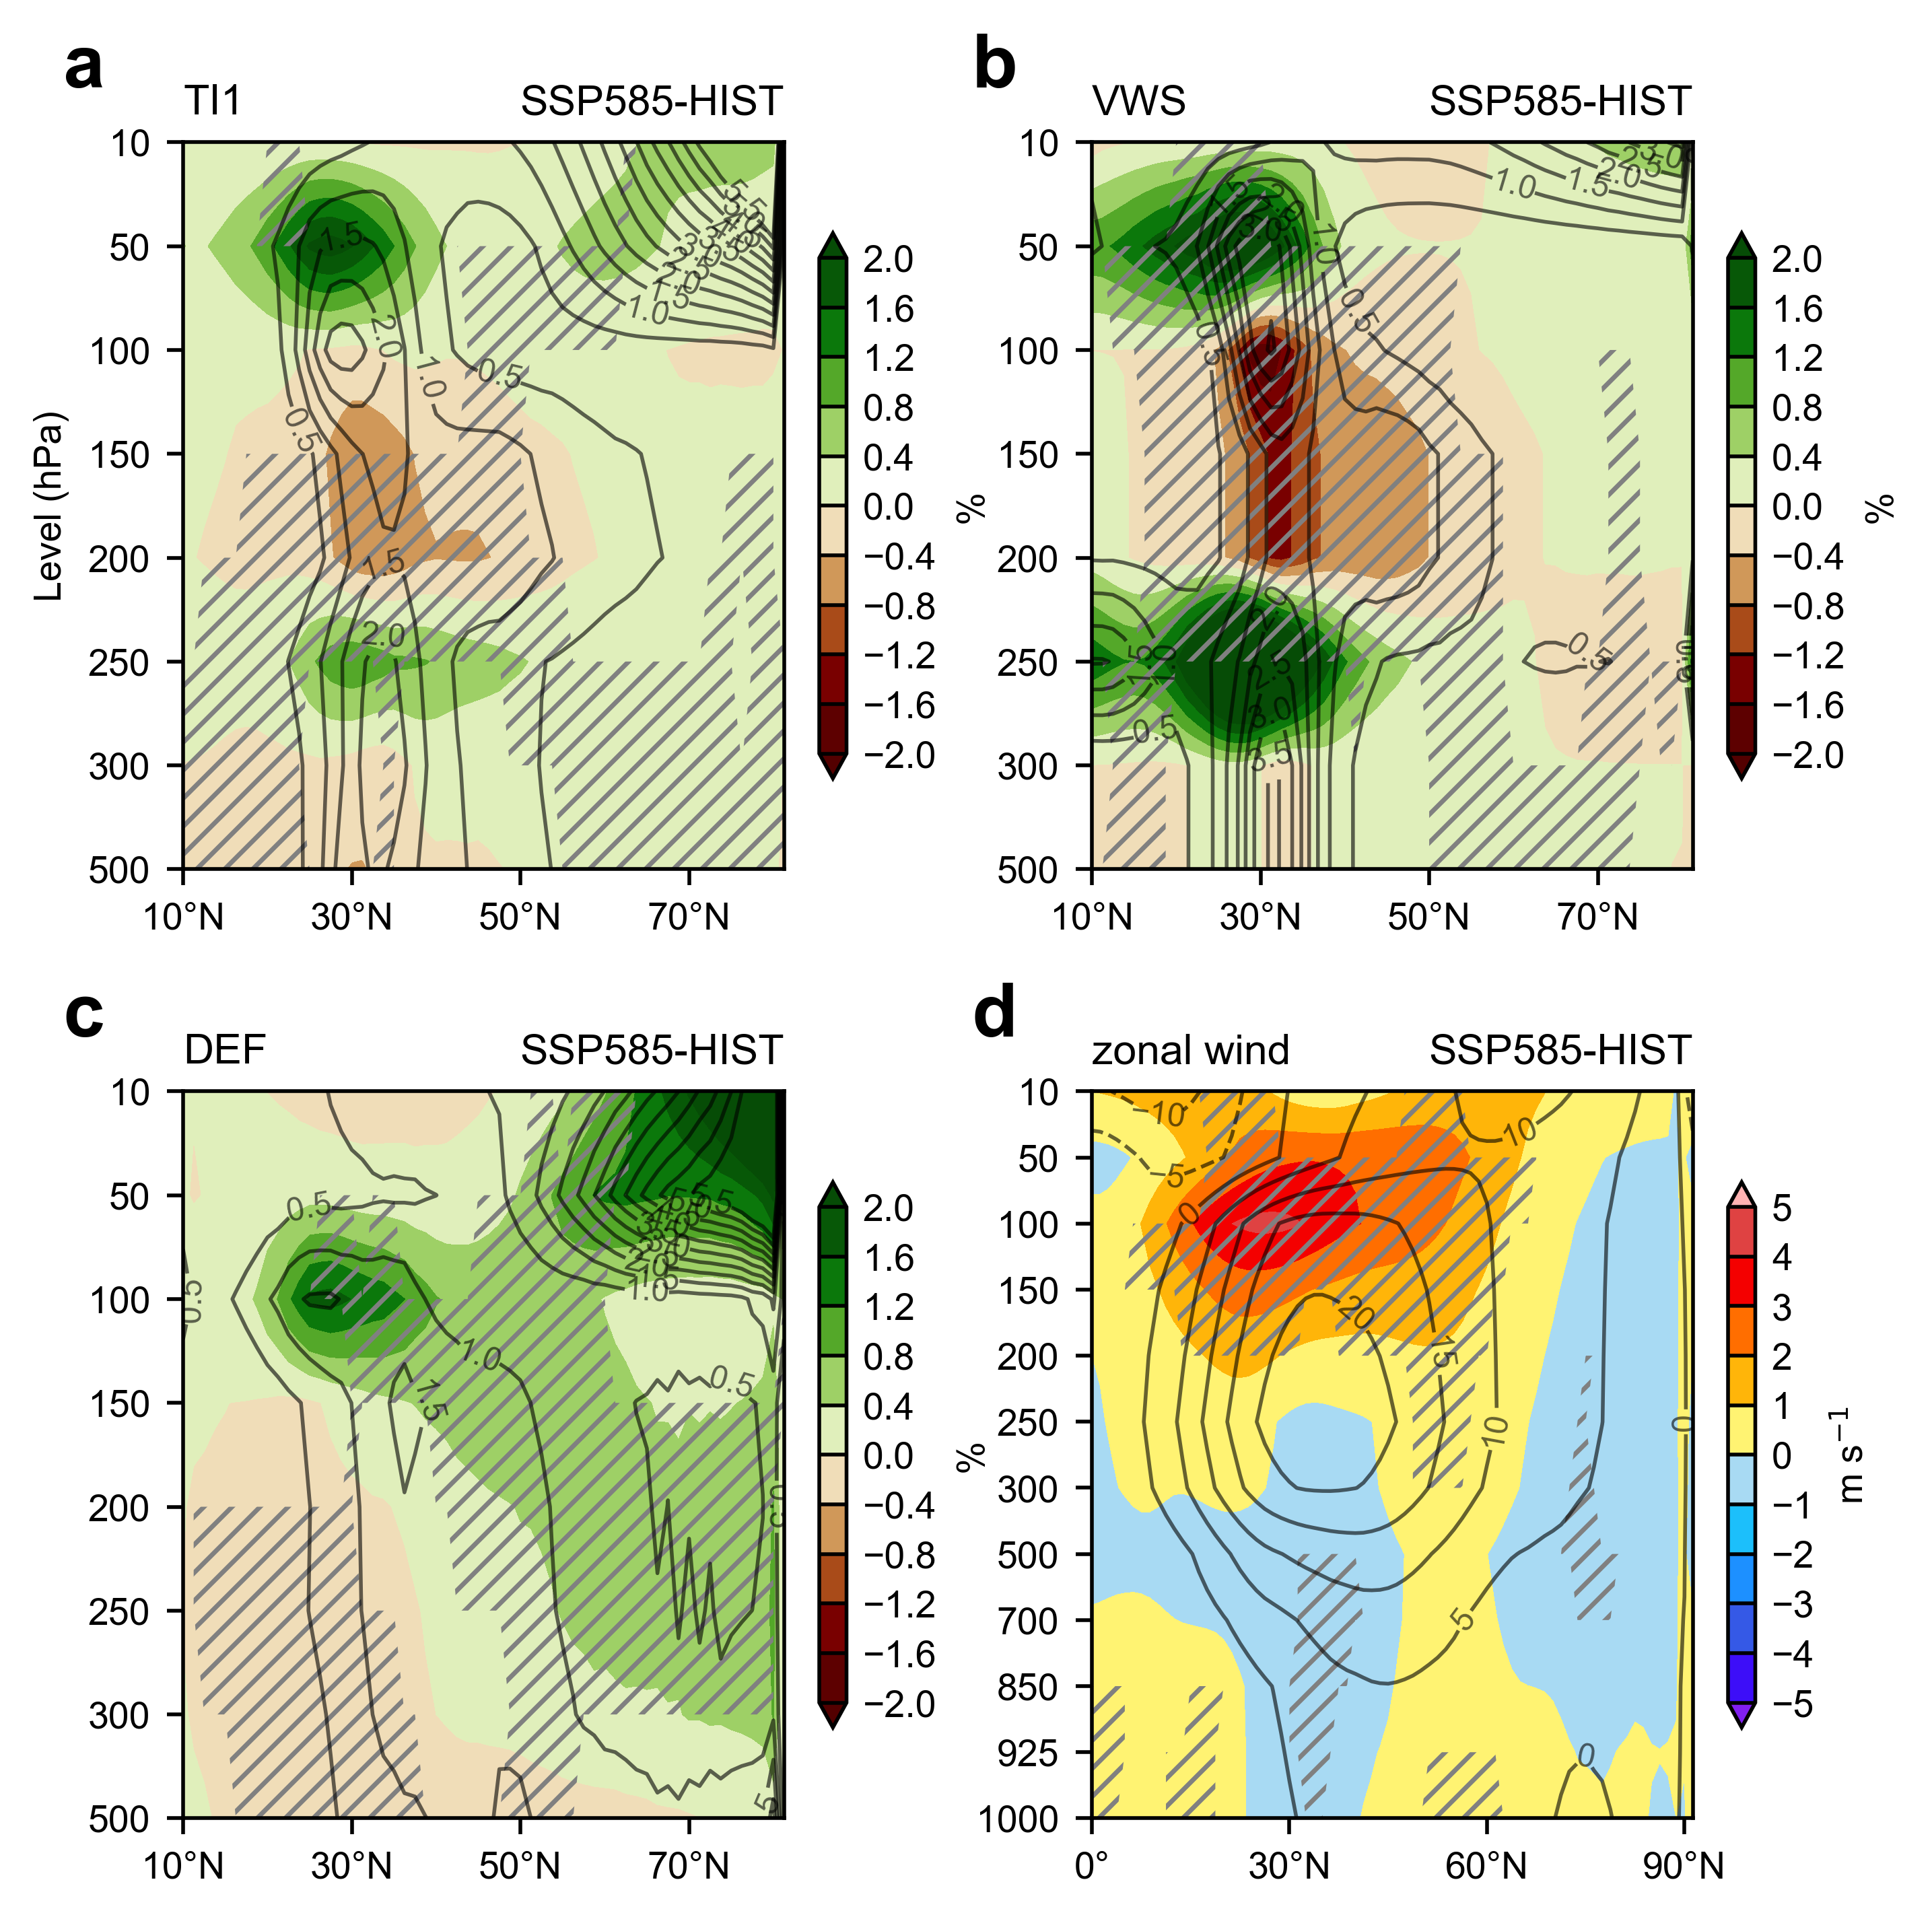

In [9]:
fig = plt.figure(figsize=(6, 6), dpi=500)
axes = [[0.1,0.55,0.35,0.36], [0.55,0.55,0.35,0.36],
        [0.1,0.08,0.35,0.36],[0.55,0.08,0.35,0.36]]

plot_meri_section(fig.add_axes(axes[0]), lat,level,level_label,change_TI_NH_mme,np.arange(-2, 2.1, 0.4),ccmap1,hist_TI_NH_mme,
                   np.arange(0, 6, .5),TI_NH_mme_consistency,np.arange(10,81,20),
                      'TI1','%',np.arange(-2, 2.1, 0.4),'a')
plot_meri_section(fig.add_axes(axes[1]), lat,level,level_label,change_VWS_NH_mme,np.arange(-2, 2.1, 0.4),ccmap1,hist_VWS_NH_mme,
                   np.arange(0, 6, .5),VWS_NH_mme_consistency,np.arange(10,81,20),
                      'VWS','%',np.arange(-2, 2.1, 0.4),'b')
plot_meri_section(fig.add_axes(axes[2]), lat,level,level_label,change_DEF_NH_mme,np.arange(-2, 2.1, 0.4),ccmap1,hist_DEF_NH_mme,
                   np.arange(0, 6, .5),DEF_NH_mme_consistency,np.arange(10,81,20),
                      'DEF','%',np.arange(-2, 2.1, 0.4),'c')

plot_meri_section(fig.add_axes(axes[3]), lat2,level2,level_label2,change_ua_NH_mme,np.arange(-5, 5.1, 1),ccmap,hist_ua_NH_mme,
                   np.arange(-20,51,5),ua_NH_mme_consistency,np.arange(0,91,30),
                      'zonal wind','m s$^{-1}$',np.arange(-5, 5.1, 1),'d')

plt.savefig(f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/figures/TI1_VWS_DEF_ua_mme_meri_section.png', format='png',dpi=600)
plt.show()